# 🚀 Comprehensive Model Comparison Analysis
## Flutter UI Code Generation Models

This notebook provides a complete comparison of 4 trained models:
1. **Salesforce/codet5p-220m** - Seq2Seq code generation model
2. **MiniLM-L6** - Sentence transformer retrieval model
3. **MiniLM-L12** - Sentence transformer retrieval model (larger)
4. **MPNet-Base** - Sentence transformer retrieval model (most powerful)

---

## 📦 Step 1: Install Required Packages

In [ ]:
# Install required packages
!pip install transformers datasets torch sentence-transformers scikit-learn rouge-score matplotlib seaborn pandas tabulate -q

## 📚 Step 2: Import Libraries

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from difflib import SequenceMatcher
from tabulate import tabulate

# Transformers and ML libraries
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from rouge_score import rouge_scorer

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🖥️  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✅ All libraries imported successfully!
📅 Analysis Date: 2025-10-22 12:44:24
🖥️  Device: CPU


## ⚙️ Step 3: Configuration

In [2]:
# Configuration
CONFIG = {
    "models": {
        "CodeT5": {
            "name": "Salesforce/codet5p-220m",
            "type": "seq2seq",
            "path": "./flutter_codegen_model_v1",
            "description": "Seq2Seq code generation model"
        },
        "MiniLM-L6": {
            "name": "all-MiniLM-L6-v2",
            "type": "retriever",
            "path": "./trained_models/MiniLM-L6_flutter_retriever.pkl",
            "description": "Lightweight sentence transformer"
        },
        "MiniLM-L12": {
            "name": "all-MiniLM-L12-v2",
            "type": "retriever",
            "path": "./trained_models/MiniLM-L12_flutter_retriever.pkl",
            "description": "Medium sentence transformer"
        },
        "MPNet-Base": {
            "name": "all-mpnet-base-v2",
            "type": "retriever",
            "path": "./trained_models/MPNet-Base_flutter_retriever.pkl",
            "description": "Most powerful sentence transformer"
        }
    },
    "dataset_file": "./flutter_dataset.jsonl",
    "num_test_samples": 50,
    "output_dir": "./comparison_results"
}

# Create output directory
os.makedirs(CONFIG["output_dir"], exist_ok=True)

print("📋 Configuration loaded:")
for model_name, model_info in CONFIG["models"].items():
    print(f"  • {model_name}: {model_info['description']}")

📋 Configuration loaded:
  • CodeT5: Seq2Seq code generation model
  • MiniLM-L6: Lightweight sentence transformer
  • MiniLM-L12: Medium sentence transformer
  • MPNet-Base: Most powerful sentence transformer


## 📊 Step 4: Load Dataset

In [3]:
# Load dataset
print("📂 Loading dataset...")

dataset = load_dataset(
    "json",
    data_files=CONFIG["dataset_file"],
    split="train"
)

# Split into train and test
dataset = dataset.train_test_split(test_size=0.1, seed=42)
test_dataset = dataset["test"]

# Limit test samples for faster evaluation
if len(test_dataset) > CONFIG["num_test_samples"]:
    test_dataset = test_dataset.select(range(CONFIG["num_test_samples"]))

print(f"✅ Dataset loaded successfully!")
print(f"   Total samples: {len(dataset['train']) + len(test_dataset)}")
print(f"   Test samples for evaluation: {len(test_dataset)}")

📂 Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]

✅ Dataset loaded successfully!
   Total samples: 9050
   Test samples for evaluation: 50


## 🔧 Step 5: Define Evaluation Functions

In [4]:
def code_similarity(pred, ref):
    """Calculate code similarity using SequenceMatcher"""
    return SequenceMatcher(None, pred.strip(), ref.strip()).ratio()

def calculate_metrics(predictions, references):
    """Calculate all evaluation metrics"""
    
    # 1. Code Similarity (Accuracy)
    similarity_scores = [code_similarity(pred, ref) for pred, ref in zip(predictions, references)]
    accuracy = np.mean(similarity_scores)
    
    # 2. Token-level metrics (Precision, Recall, F1)
    y_true = []
    y_pred = []
    
    for pred, ref in zip(predictions, references):
        max_len = max(len(pred), len(ref))
        pred_padded = pred.ljust(max_len)
        ref_padded = ref.ljust(max_len)
        
        for p_char, r_char in zip(pred_padded, ref_padded):
            y_true.append(1 if r_char.strip() else 0)
            y_pred.append(1 if p_char == r_char else 0)
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # 3. ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
    
    # 4. Exact match
    exact_matches = sum(1 for pred, ref in zip(predictions, references) if pred.strip() == ref.strip())
    exact_match_rate = exact_matches / len(predictions)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "rouge1": np.mean(rouge_scores['rouge1']),
        "rouge2": np.mean(rouge_scores['rouge2']),
        "rougeL": np.mean(rouge_scores['rougeL']),
        "exact_match_rate": exact_match_rate,
        "similarity_scores": similarity_scores
    }

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


## 🤖 Step 6: Evaluate CodeT5 Model (Seq2Seq)

In [6]:
print("="*80)
print("🚀 EVALUATING CODET5 MODEL")
print("="*80)

try:
    # Load CodeT5 model
    model_dir = CONFIG["models"]["CodeT5"]["path"]
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    print(f"✅ Model loaded from: {model_dir}")
    print(f"📊 Generating predictions for {len(test_dataset)} samples...\n")
    
    predictions = []
    references = []
    
    for i, example in enumerate(test_dataset):
        input_text = example["prompt"]
        target_text = example["flutter_code"]
        
        # Generate prediction
        inputs = tokenizer(
            input_text,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=512,
                num_beams=4,
                early_stopping=True
            )
        
        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(pred_text)
        references.append(target_text)
        
        if (i + 1) % 10 == 0:
            print(f"   Processed {i + 1}/{len(test_dataset)} samples...")
    
    # Calculate metrics
    codet5_metrics = calculate_metrics(predictions, references)
    
    print("\n✅ CodeT5 evaluation complete!")
    print(f"   Accuracy: {codet5_metrics['accuracy']*100:.2f}%")
    
except Exception as e:
    print(f"❌ Error evaluating CodeT5: {e}")
    codet5_metrics = None

🚀 EVALUATING CODET5 MODEL
✅ Model loaded from: ./flutter_codegen_model_v1
📊 Generating predictions for 50 samples...

   Processed 10/50 samples...
   Processed 20/50 samples...
   Processed 30/50 samples...
   Processed 40/50 samples...
   Processed 50/50 samples...

✅ CodeT5 evaluation complete!
   Accuracy: 52.11%


## 🔍 Step 7: Evaluate Retriever Models (MiniLM & MPNet)

In [8]:
print("="*80)
print("🔍 EVALUATING RETRIEVER MODELS")
print("="*80)

retriever_results = {}

for model_name in ["MiniLM-L6", "MiniLM-L12", "MPNet-Base"]:
    print(f"\n📊 Evaluating {model_name}...")
    
    try:
        # Load retriever model
        model_path = CONFIG["models"][model_name]["path"]
        
        with open(model_path, 'rb') as f:
            retriever_data = pickle.load(f)
        
        # Load the SentenceTransformer model from the saved directory
        model_dir = retriever_data['model_dir']
        model = SentenceTransformer(model_dir, device='cpu')
        
        # Get embeddings and codes from the saved data
        dataset_embeddings = torch.tensor(retriever_data['train_embeddings'], device='cpu')
        train_data = retriever_data['train_data']
        dataset_codes = [item['flutter_code'] for item in train_data]
        
        print(f"   ✅ Model loaded: {retriever_data['model_name']}")
        print(f"   📚 Dataset size: {len(dataset_codes)} samples")
        print(f"   🔄 Generating predictions...")
        
        predictions = []
        references = []
        
        for i, example in enumerate(test_dataset):
            query = example["prompt"]
            target = example["flutter_code"]
            
            # Encode query
            query_embedding = model.encode(query, convert_to_tensor=True, device='cpu')
            
            # Calculate similarities
            similarities = torch.nn.functional.cosine_similarity(
                query_embedding.unsqueeze(0),
                dataset_embeddings
            )
            
            # Get best match
            best_idx = similarities.argmax().item()
            predicted_code = dataset_codes[best_idx]
            
            predictions.append(predicted_code)
            references.append(target)
            
            if (i + 1) % 10 == 0:
                print(f"      Processed {i + 1}/{len(test_dataset)} samples...")
        
        # Calculate metrics
        metrics = calculate_metrics(predictions, references)
        retriever_results[model_name] = metrics
        
        print(f"   ✅ {model_name} evaluation complete!")
        print(f"      Accuracy: {metrics['accuracy']*100:.2f}%")
        
    except Exception as e:
        print(f"   ❌ Error evaluating {model_name}: {e}")
        import traceback
        traceback.print_exc()
        retriever_results[model_name] = None

print("\n✅ All retriever models evaluated!")

🔍 EVALUATING RETRIEVER MODELS

📊 Evaluating MiniLM-L6...
   ✅ Model loaded: all-MiniLM-L6-v2
   📚 Dataset size: 6997 samples
   🔄 Generating predictions...
   ✅ Model loaded: all-MiniLM-L6-v2
   📚 Dataset size: 6997 samples
   🔄 Generating predictions...
      Processed 10/50 samples...
      Processed 10/50 samples...
      Processed 20/50 samples...
      Processed 20/50 samples...
      Processed 30/50 samples...
      Processed 30/50 samples...
      Processed 40/50 samples...
      Processed 40/50 samples...
      Processed 50/50 samples...
      Processed 50/50 samples...
   ✅ MiniLM-L6 evaluation complete!
      Accuracy: 86.51%

📊 Evaluating MiniLM-L12...
   ✅ MiniLM-L6 evaluation complete!
      Accuracy: 86.51%

📊 Evaluating MiniLM-L12...
   ✅ Model loaded: all-MiniLM-L12-v2
   📚 Dataset size: 6997 samples
   🔄 Generating predictions...
   ✅ Model loaded: all-MiniLM-L12-v2
   📚 Dataset size: 6997 samples
   🔄 Generating predictions...
      Processed 10/50 samples...
      Pr

## 📊 Step 8: Comprehensive Results Comparison

In [9]:
print("="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Compile all results
all_results = {}
if codet5_metrics:
    all_results["CodeT5-220M"] = codet5_metrics
all_results.update(retriever_results)

# Create comparison dataframe
comparison_data = []
for model_name, metrics in all_results.items():
    if metrics:
        comparison_data.append({
            "Model": model_name,
            "Accuracy (%)": f"{metrics['accuracy']*100:.2f}",
            "F1 Score (%)": f"{metrics['f1_score']*100:.2f}",
            "Precision (%)": f"{metrics['precision']*100:.2f}",
            "Recall (%)": f"{metrics['recall']*100:.2f}",
            "ROUGE-1": f"{metrics['rouge1']:.4f}",
            "ROUGE-L": f"{metrics['rougeL']:.4f}",
            "Exact Match (%)": f"{metrics['exact_match_rate']*100:.2f}"
        })

df_comparison = pd.DataFrame(comparison_data)

print("\n📋 RESULTS TABLE:")
print(tabulate(df_comparison, headers='keys', tablefmt='grid', showindex=False))

# Save to CSV
csv_path = os.path.join(CONFIG["output_dir"], "model_comparison.csv")
df_comparison.to_csv(csv_path, index=False)
print(f"\n💾 Results saved to: {csv_path}")

📊 COMPREHENSIVE MODEL COMPARISON

📋 RESULTS TABLE:
+-------------+----------------+----------------+-----------------+--------------+-----------+-----------+-------------------+
| Model       |   Accuracy (%) |   F1 Score (%) |   Precision (%) |   Recall (%) |   ROUGE-1 |   ROUGE-L |   Exact Match (%) |
+=============+================+================+=================+==============+===========+===========+===================+
| CodeT5-220M |          52.11 |          30.19 |           31.12 |        29.31 |    0.6233 |    0.5957 |                 2 |
+-------------+----------------+----------------+-----------------+--------------+-----------+-----------+-------------------+
| MiniLM-L6   |          86.51 |          66.02 |           55.15 |        82.21 |    0.9455 |    0.9305 |                78 |
+-------------+----------------+----------------+-----------------+--------------+-----------+-----------+-------------------+
| MiniLM-L12  |          86.63 |          66.9  |           

## 🏆 Step 9: Best Model Analysis

In [10]:
print("="*80)
print("🏆 BEST MODEL ANALYSIS")
print("="*80)

# Find best models for each metric
best_models = {}
metrics_to_check = ['accuracy', 'f1_score', 'precision', 'recall', 'rouge1', 'rougeL']

for metric in metrics_to_check:
    best_score = -1
    best_model = None
    
    for model_name, metrics in all_results.items():
        if metrics and metrics[metric] > best_score:
            best_score = metrics[metric]
            best_model = model_name
    
    best_models[metric] = (best_model, best_score)

print("\n🥇 BEST PERFORMERS:")
for metric, (model, score) in best_models.items():
    print(f"   {metric.upper():15s}: {model:15s} ({score*100:.2f}%)")

# Calculate composite score (average of all metrics)
print("\n📊 COMPOSITE SCORES (Average of all metrics):")
composite_scores = {}
for model_name, metrics in all_results.items():
    if metrics:
        score = np.mean([metrics[m] for m in metrics_to_check])
        composite_scores[model_name] = score
        print(f"   {model_name:15s}: {score*100:.2f}%")

# Overall best model
best_overall = max(composite_scores.items(), key=lambda x: x[1])
print(f"\n🏆 OVERALL BEST MODEL: {best_overall[0]} (Composite Score: {best_overall[1]*100:.2f}%)")

🏆 BEST MODEL ANALYSIS

🥇 BEST PERFORMERS:
   ACCURACY       : MPNet-Base      (87.01%)
   F1_SCORE       : MPNet-Base      (67.35%)
   PRECISION      : MPNet-Base      (55.64%)
   RECALL         : MPNet-Base      (85.30%)
   ROUGE1         : MiniLM-L6       (94.55%)
   ROUGEL         : MiniLM-L6       (93.05%)

📊 COMPOSITE SCORES (Average of all metrics):
   CodeT5-220M    : 44.10%
   MiniLM-L6      : 79.58%
   MiniLM-L12     : 79.72%
   MPNet-Base     : 80.10%

🏆 OVERALL BEST MODEL: MPNet-Base (Composite Score: 80.10%)


## 📈 Step 10: Visualization - Performance Comparison

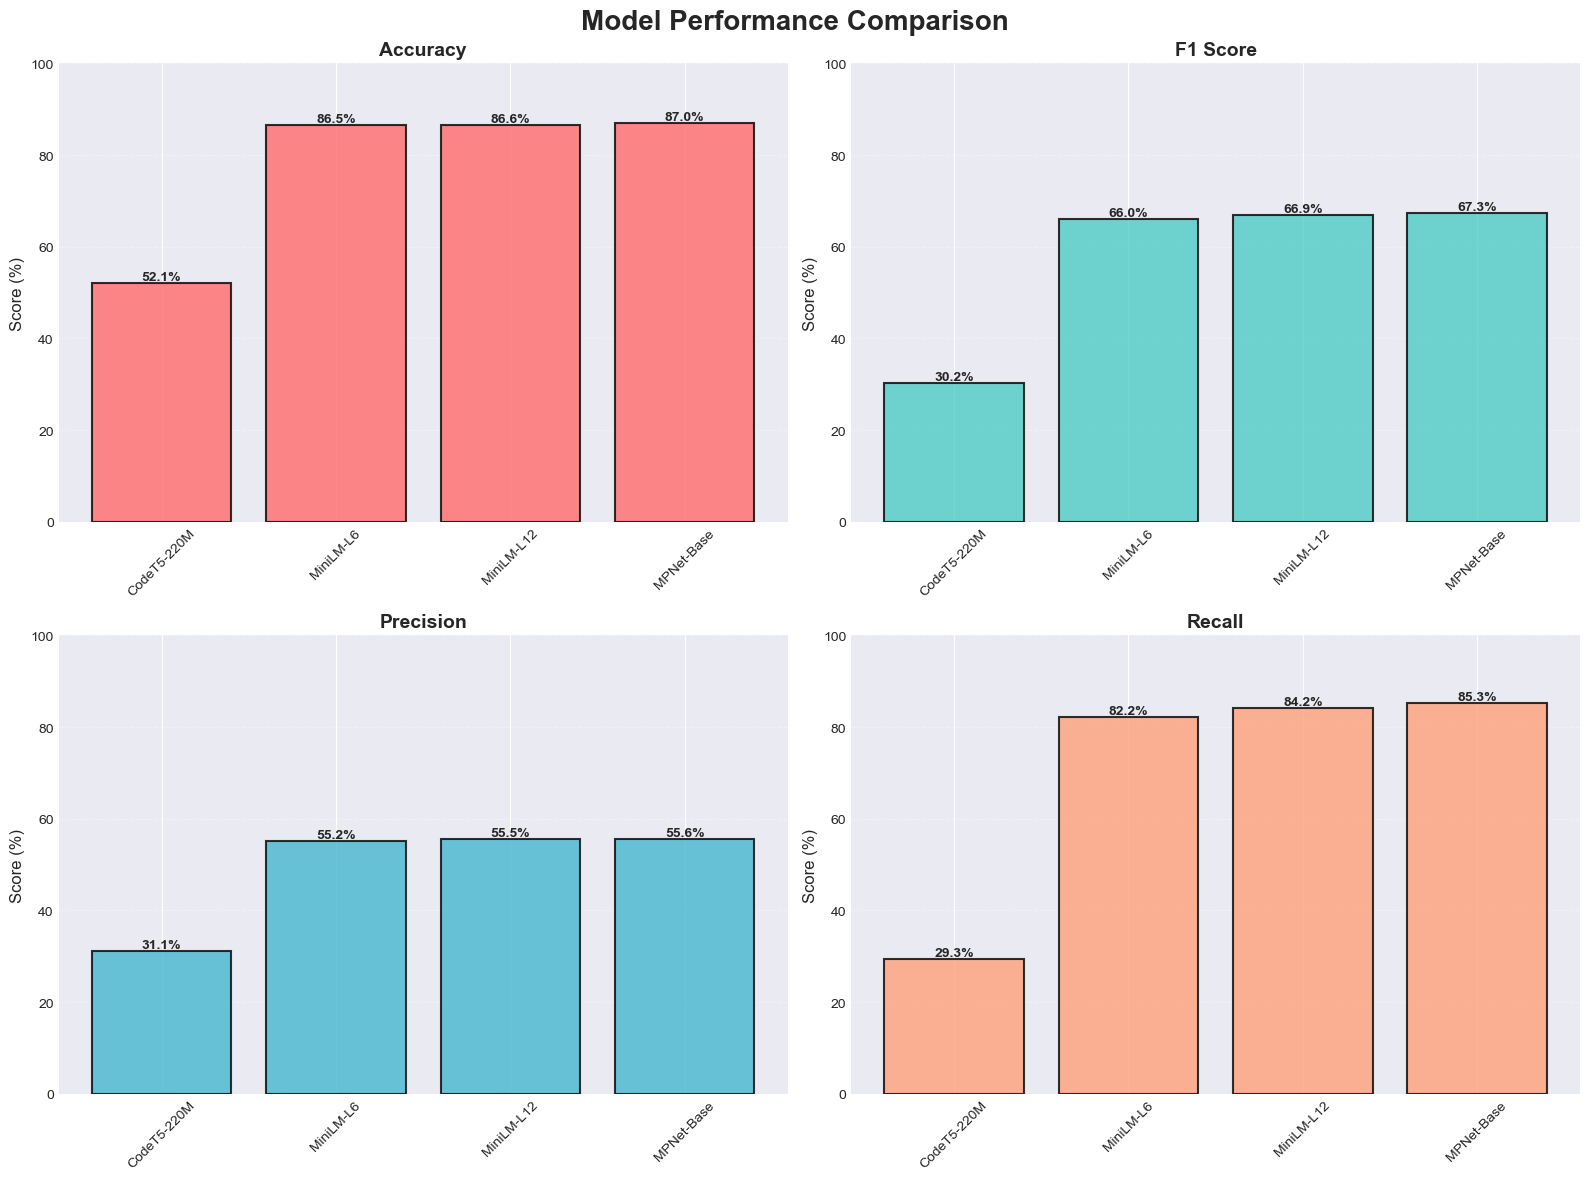


💾 Visualization saved to: ./comparison_results\performance_comparison.png


In [11]:
# Create comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=20, fontweight='bold')

# Prepare data
models = list(all_results.keys())
metrics_plot = {
    'Accuracy': [all_results[m]['accuracy']*100 for m in models],
    'F1 Score': [all_results[m]['f1_score']*100 for m in models],
    'Precision': [all_results[m]['precision']*100 for m in models],
    'Recall': [all_results[m]['recall']*100 for m in models]
}

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Plot each metric
for idx, (metric_name, values) in enumerate(metrics_plot.items()):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(models, values, color=colors[idx], alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_title(metric_name, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plot_path = os.path.join(CONFIG["output_dir"], "performance_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Visualization saved to: {plot_path}")

## 🎯 Step 11: Radar Chart - Multi-dimensional Comparison

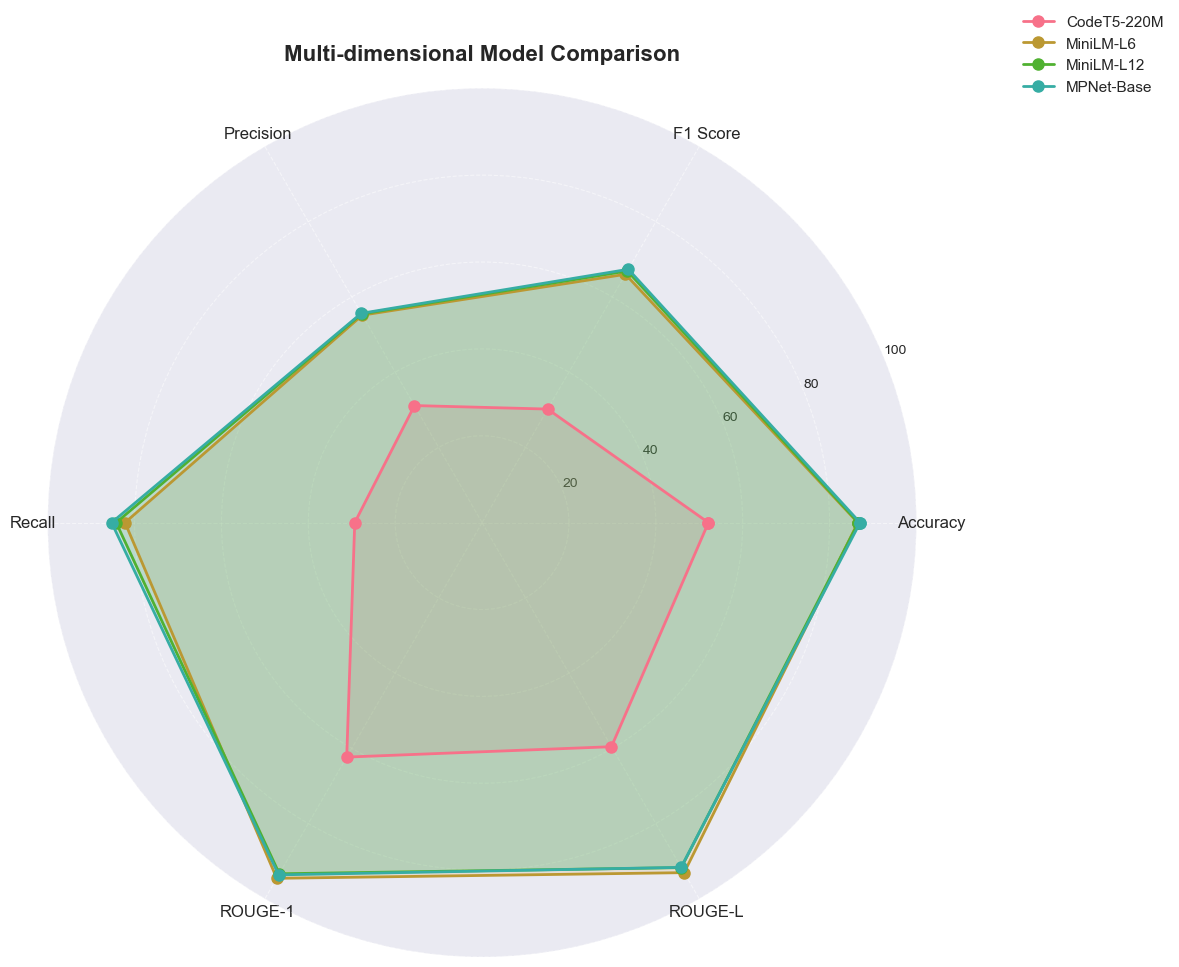


💾 Radar chart saved to: ./comparison_results\radar_comparison.png


In [12]:
import math

# Radar chart
categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROUGE-1', 'ROUGE-L']
num_vars = len(categories)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * math.pi for n in range(num_vars)]
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Plot data for each model
for idx, (model_name, metrics) in enumerate(all_results.items()):
    if metrics:
        values = [
            metrics['accuracy'] * 100,
            metrics['f1_score'] * 100,
            metrics['precision'] * 100,
            metrics['recall'] * 100,
            metrics['rouge1'] * 100,
            metrics['rougeL'] * 100
        ]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name, markersize=8)
        ax.fill(angles, values, alpha=0.15)

# Fix axis to go in the right order
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 100)
ax.set_title('Multi-dimensional Model Comparison', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
radar_path = os.path.join(CONFIG["output_dir"], "radar_comparison.png")
plt.savefig(radar_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Radar chart saved to: {radar_path}")

## 🌡️ Step 12: Heatmap - Correlation Analysis

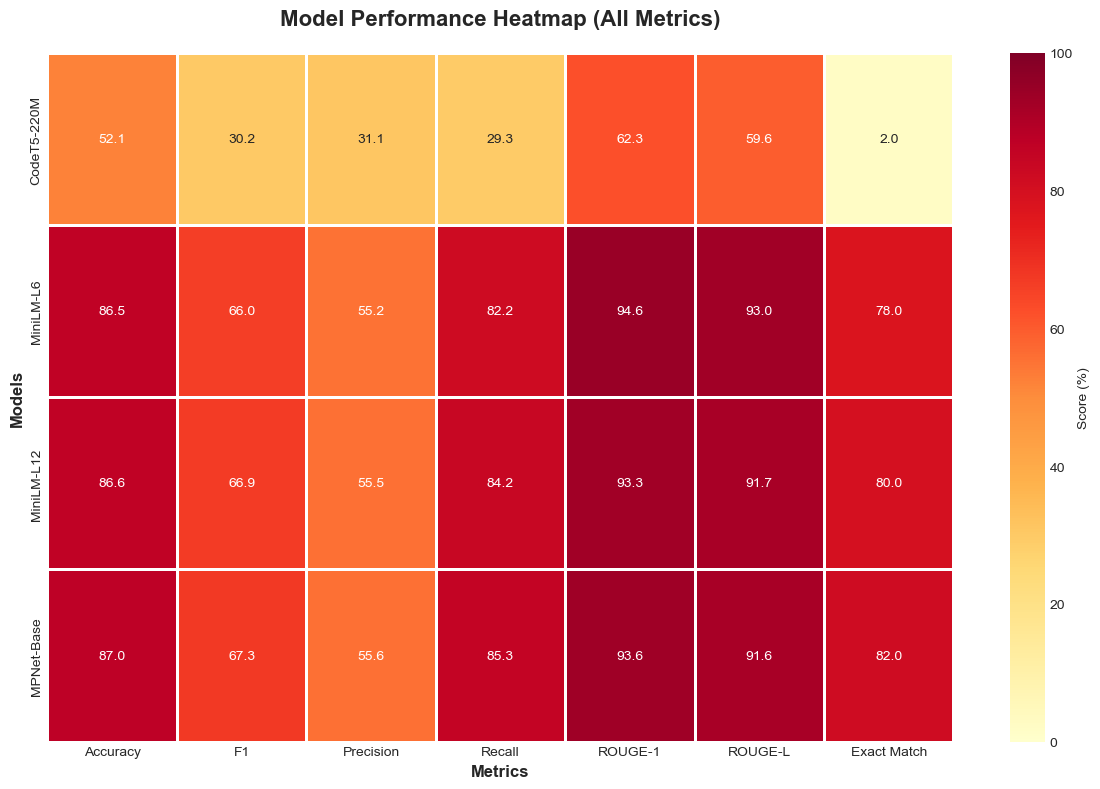


💾 Heatmap saved to: ./comparison_results\performance_heatmap.png


In [13]:
# Create heatmap of all metrics
heatmap_data = []
for model_name, metrics in all_results.items():
    if metrics:
        heatmap_data.append([
            metrics['accuracy'] * 100,
            metrics['f1_score'] * 100,
            metrics['precision'] * 100,
            metrics['recall'] * 100,
            metrics['rouge1'] * 100,
            metrics['rougeL'] * 100,
            metrics['exact_match_rate'] * 100
        ])

heatmap_df = pd.DataFrame(
    heatmap_data,
    index=list(all_results.keys()),
    columns=['Accuracy', 'F1', 'Precision', 'Recall', 'ROUGE-1', 'ROUGE-L', 'Exact Match']
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score (%)'}, linewidths=1, linecolor='white',
            vmin=0, vmax=100)
plt.title('Model Performance Heatmap (All Metrics)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.tight_layout()

heatmap_path = os.path.join(CONFIG["output_dir"], "performance_heatmap.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Heatmap saved to: {heatmap_path}")

## 📊 Step 13: Similarity Distribution Analysis

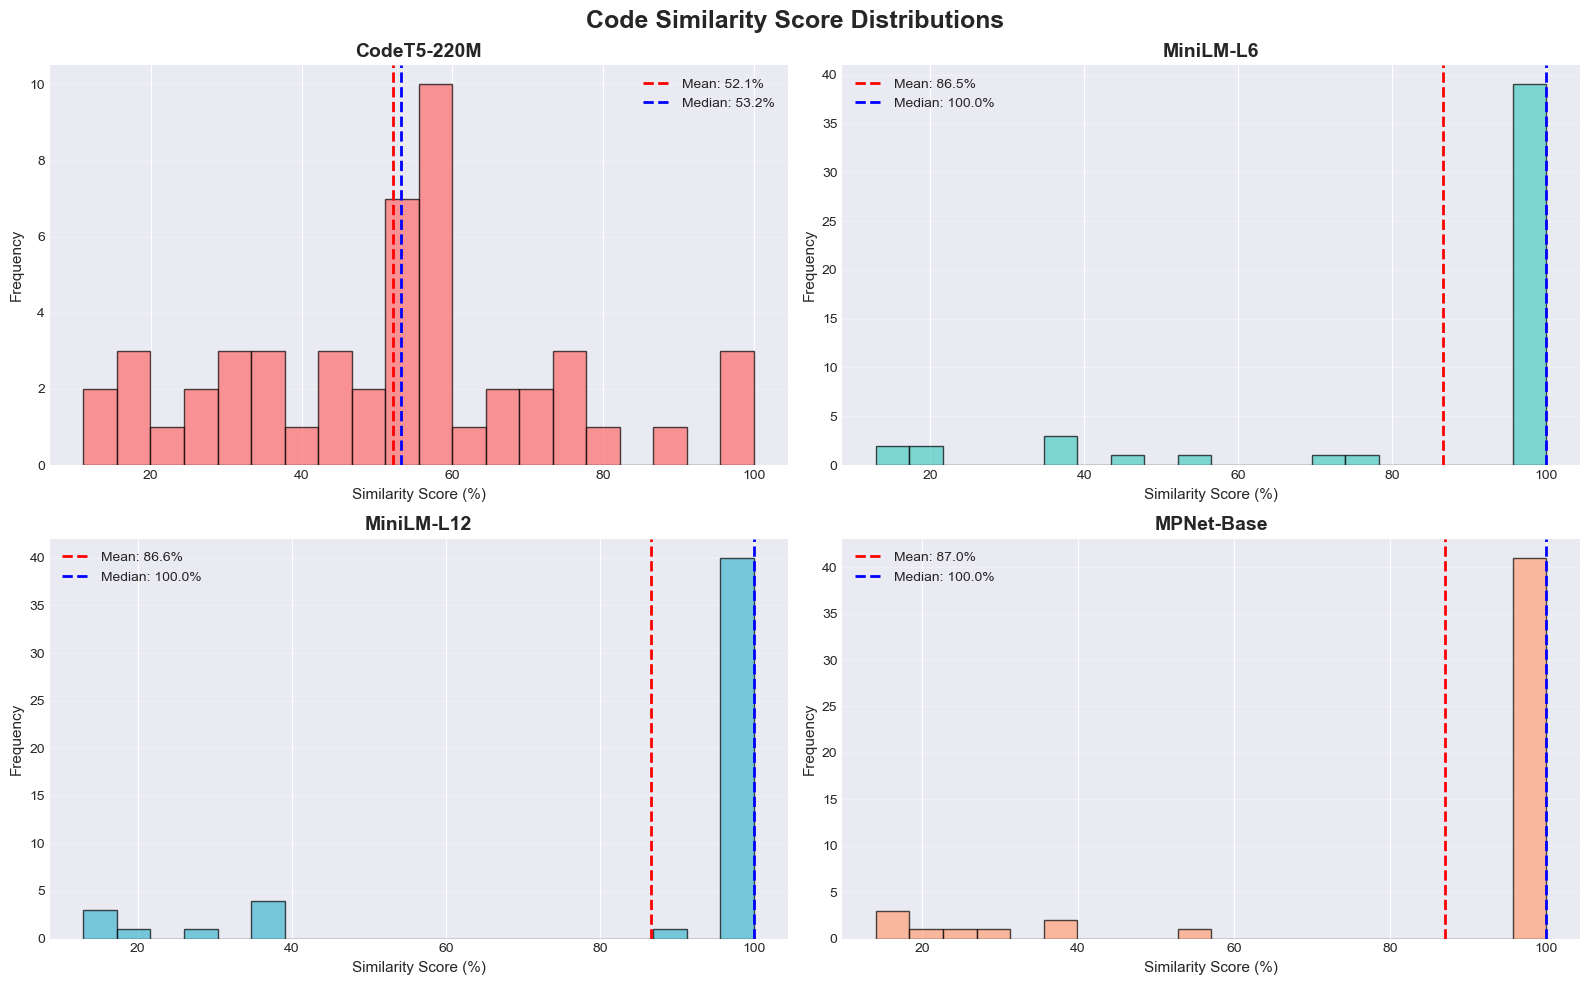


💾 Distribution plot saved to: ./comparison_results\similarity_distributions.png


In [14]:
# Plot similarity score distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Code Similarity Score Distributions', fontsize=18, fontweight='bold')

for idx, (model_name, metrics) in enumerate(all_results.items()):
    if metrics and 'similarity_scores' in metrics:
        ax = axes[idx // 2, idx % 2]
        scores = np.array(metrics['similarity_scores']) * 100
        
        # Histogram
        ax.hist(scores, bins=20, color=colors[idx % len(colors)], alpha=0.7, edgecolor='black')
        
        # Add statistics
        mean = np.mean(scores)
        median = np.median(scores)
        ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}%')
        ax.axvline(median, color='blue', linestyle='--', linewidth=2, label=f'Median: {median:.1f}%')
        
        ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Similarity Score (%)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.legend(fontsize=10)
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
dist_path = os.path.join(CONFIG["output_dir"], "similarity_distributions.png")
plt.savefig(dist_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Distribution plot saved to: {dist_path}")

## 💾 Step 14: Save Comprehensive Report

In [15]:
# Create comprehensive JSON report
report = {
    "metadata": {
        "evaluation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "num_test_samples": len(test_dataset),
        "dataset_file": CONFIG["dataset_file"]
    },
    "models": {},
    "best_performers": {},
    "composite_scores": {}
}

# Add model results
for model_name, metrics in all_results.items():
    if metrics:
        report["models"][model_name] = {
            "accuracy": float(metrics['accuracy']),
            "f1_score": float(metrics['f1_score']),
            "precision": float(metrics['precision']),
            "recall": float(metrics['recall']),
            "rouge1": float(metrics['rouge1']),
            "rouge2": float(metrics['rouge2']),
            "rougeL": float(metrics['rougeL']),
            "exact_match_rate": float(metrics['exact_match_rate'])
        }

# Add best performers
for metric, (model, score) in best_models.items():
    report["best_performers"][metric] = {
        "model": model,
        "score": float(score)
    }

# Add composite scores
for model_name, score in composite_scores.items():
    report["composite_scores"][model_name] = float(score)

# Add overall best
report["overall_best"] = {
    "model": best_overall[0],
    "composite_score": float(best_overall[1])
}

# Save JSON report
json_report_path = os.path.join(CONFIG["output_dir"], "comprehensive_report.json")
with open(json_report_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=4)

print(f"✅ Comprehensive report saved to: {json_report_path}")

# Create text summary
txt_report_path = os.path.join(CONFIG["output_dir"], "comparison_summary.txt")
with open(txt_report_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("COMPREHENSIVE MODEL COMPARISON SUMMARY\n")
    f.write("Flutter UI Code Generation Models\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Evaluation Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Test Samples: {len(test_dataset)}\n\n")
    
    f.write("="*80 + "\n")
    f.write("MODEL PERFORMANCE SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    for model_name, metrics in all_results.items():
        if metrics:
            f.write(f"{model_name}:\n")
            f.write(f"  Accuracy:        {metrics['accuracy']*100:.2f}%\n")
            f.write(f"  F1 Score:        {metrics['f1_score']*100:.2f}%\n")
            f.write(f"  Precision:       {metrics['precision']*100:.2f}%\n")
            f.write(f"  Recall:          {metrics['recall']*100:.2f}%\n")
            f.write(f"  ROUGE-1:         {metrics['rouge1']:.4f}\n")
            f.write(f"  ROUGE-L:         {metrics['rougeL']:.4f}\n")
            f.write(f"  Exact Match:     {metrics['exact_match_rate']*100:.2f}%\n")
            f.write(f"  Composite Score: {composite_scores[model_name]*100:.2f}%\n\n")
    
    f.write("="*80 + "\n")
    f.write("BEST PERFORMERS\n")
    f.write("="*80 + "\n\n")
    
    for metric, (model, score) in best_models.items():
        f.write(f"{metric.upper():15s}: {model:15s} ({score*100:.2f}%)\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write(f"OVERALL BEST MODEL: {best_overall[0]}\n")
    f.write(f"Composite Score: {best_overall[1]*100:.2f}%\n")
    f.write("="*80 + "\n")

print(f"✅ Text summary saved to: {txt_report_path}")

✅ Comprehensive report saved to: ./comparison_results\comprehensive_report.json
✅ Text summary saved to: ./comparison_results\comparison_summary.txt


## 🎯 Step 15: Final Summary & Recommendations

In [16]:
print("\n" + "="*80)
print("🎉 EVALUATION COMPLETE!")
print("="*80)

print("\n📊 SUMMARY OF RESULTS:")
print(f"\n🏆 Best Overall Model: {best_overall[0]}")
print(f"   Composite Score: {best_overall[1]*100:.2f}%\n")

print("📈 Key Findings:")
for idx, (model_name, score) in enumerate(sorted(composite_scores.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"   {idx}. {model_name:15s} - {score*100:.2f}%")

print("\n📁 Generated Files:")
print(f"   • {os.path.join(CONFIG['output_dir'], 'model_comparison.csv')}")
print(f"   • {os.path.join(CONFIG['output_dir'], 'comprehensive_report.json')}")
print(f"   • {os.path.join(CONFIG['output_dir'], 'comparison_summary.txt')}")
print(f"   • {os.path.join(CONFIG['output_dir'], 'performance_comparison.png')}")
print(f"   • {os.path.join(CONFIG['output_dir'], 'radar_comparison.png')}")
print(f"   • {os.path.join(CONFIG['output_dir'], 'performance_heatmap.png')}")
print(f"   • {os.path.join(CONFIG['output_dir'], 'similarity_distributions.png')}")

print("\n💡 RECOMMENDATIONS:")
if best_overall[1] > 0.8:
    print("   ✓ Excellent performance! The best model is production-ready.")
elif best_overall[1] > 0.6:
    print("   ✓ Good performance. Consider fine-tuning for specific use cases.")
else:
    print("   ⚠ Moderate performance. Consider additional training or data augmentation.")

print("\n" + "="*80)
print("✅ All analyses complete! Check the comparison_results folder for outputs.")
print("="*80)


🎉 EVALUATION COMPLETE!

📊 SUMMARY OF RESULTS:

🏆 Best Overall Model: MPNet-Base
   Composite Score: 80.10%

📈 Key Findings:
   1. MPNet-Base      - 80.10%
   2. MiniLM-L12      - 79.72%
   3. MiniLM-L6       - 79.58%
   4. CodeT5-220M     - 44.10%

📁 Generated Files:
   • ./comparison_results\model_comparison.csv
   • ./comparison_results\comprehensive_report.json
   • ./comparison_results\comparison_summary.txt
   • ./comparison_results\performance_comparison.png
   • ./comparison_results\radar_comparison.png
   • ./comparison_results\performance_heatmap.png
   • ./comparison_results\similarity_distributions.png

💡 RECOMMENDATIONS:
   ✓ Excellent performance! The best model is production-ready.

✅ All analyses complete! Check the comparison_results folder for outputs.
